# loadest-gp
LOAD ESTimator (LOADEST) is a software program for estimating some constituent using surrogate variables (covariates).
However, LOADEST has several serious limitations, and it has been all but replaced by another model known as WRTDS.
`loadest-gp` essentially reimplements WRTDS as a Gaussian process.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/discontinuum/blob/main/notebooks/loadest-gp-demo.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/thodson-usgs/discontinuum/main?labpath=notebooks%2Floadest-gp-demo.ipynb)

In [ ]:
# install the latest version of discontinuum
!pip install git+https://github.com/thodson-usgs/discontinuum.git

In [1]:
import matplotlib.pyplot as plt
import xarray as xr


from discontinuum.utils import aggregate_to_daily

In [2]:
# setup

# SF Coeur D Alene River 
site = "12413470"
start_date = "1988-10-01" 
end_date = "2021-09-30" 

# Choptank River at Greensboro, MD
#site = "01491000" 
#start_date = "1979-10-01"
#end_date = "2011-09-30"

characteristic = 'Inorganic nitrogen (nitrate and nitrite)'
fraction = 'Dissolved'

First, download the data. In `discontinuum`...

In [3]:
# download data
from loadest_gp.providers import usgs

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join='inner')

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(


Next, try fitting the model. Depending on your hardware, this may take between several seconds and several minutes. The first fit also compiles the model, which takes longer. After running it once, try running the cell again and note the difference in wall time.

In [5]:
%%time
# fit model

from loadest_gp import LoadestGP

model = LoadestGP()
model.fit(target=training_data['concentration'], covariates=training_data[['time','flow']])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:03:09 logp = -149.56, ||grad|| = 0.20105

CPU times: user 19.4 s, sys: 1.06 s, total: 20.5 s
Wall time: 7.18 s


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

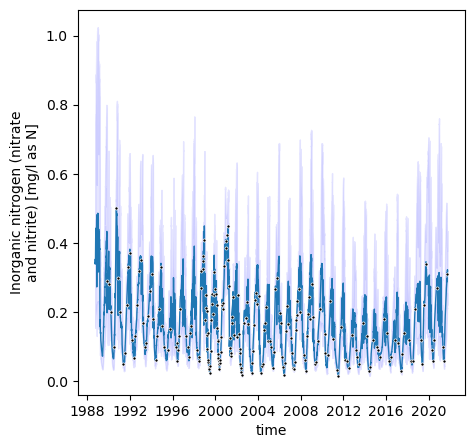

In [6]:
# plot result
model.plot(daily[['time','flow']])

Like WRTDS, we can also plot the variable space:

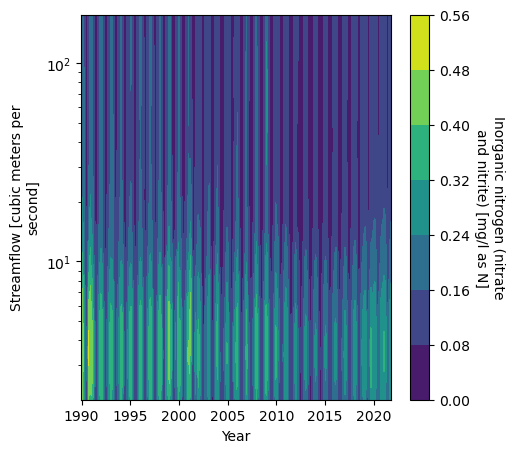

In [7]:
model.contourf(levels=5)
plt.show()

For plotting, we don't need to simulate the full covariance matrix. Instead, we use its diagonal to compute confidence intervals, but for most other uses we need to simulate the full covariance..

In [ ]:
# simulate concentration
sim_slice = daily[['time','flow']].sel(time=slice("1990","2020"))

sim = model.sample(sim_slice)

In [ ]:
# simulate flux
def to_flux(concentration, flow):
    flux = concentration * flow * 86400 * 1e-6
    flux.attrs = sim.attrs
    flux.attrs['units'] = 'kilograms per day'
    flux.attrs['standard_name'] = 'flux'
    return flux

In [ ]:
import matplotlib.pyplot as plt

def plot_annual_sum(sim):
    """Describe
    """
    fig, ax = plt.subplots()
    annual = sim.resample(time='YE').sum()
    annual.attrs['units'] = 'kilograms per year'
    annual.attrs['short_name'] = 'flux'
    
    annual.to_dataframe(name=annual.attrs['short_name']).boxplot(by='time', showfliers=False, grid=False, ax=ax)
    ax.set_ylabel('{}\n[{}]'.format(annual.attrs['long_name'], annual.attrs['units']))
    ax.set_xlabel('Year')
    ax.tick_params(axis='x', labelrotation=90)

    labels = ['' if (year % 5 != 0) else year for i, year in enumerate(annual.time.dt.year.values)]
    ax.set_xticklabels(labels)
    ax.set_title('')
    #fig.suptitle('')
    return ax

In [ ]:
flux = to_flux(sim, sim_slice['flow'])
plot_annual_sum(flux)

In [ ]:
# now let's create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("2005","2005"))

In [ ]:
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = to_flux(counterfactual_sim, sim_slice['flow'])

In [ ]:
plot_annual_sum(counterfactual_sim)